In [1]:
!pip install --quiet -U ipykernel
!pip install --quiet -U langchain
!pip install --quiet -U langchain-openai
!pip install --quiet -U langgraph
!pip install --quiet -U langchainhub
!pip install --quiet -U tavily-python
!pip install --quiet -U langchain-community
!pip install --quiet -U python-dotenv==1.0.1
!pip install --quiet -U langchain-anthropic
!pip install --quiet -U mlflow
!pip install --quiet -U openai

In [2]:
import os
from typing import Dict, List, Optional, Any, Literal

# Tavily API
from tavily import TavilyClient

# Langchain
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_classic.vectorstores import Chroma
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# Langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import CompiledStateGraph

# Evaluation 
import mlflow

# Anthropic
from anthropic import Anthropic

# Environment Variables
from dotenv import load_dotenv
from IPython.display import Image, display

/Users/rmiles/Desktop/local_projects/Projects/Healthbot/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [3]:
load_dotenv("config.env")

base_llm = ChatOpenAI(
    model="gpt-5.1",
    temperature=0.0,
    #verbosity="high",
    #reasoning_effort="high",
    #logprobs=True,
    #top_logprobs=3,
)


In [11]:
small_llm = ChatOpenAI(
    model = "gpt-5-nano",
    temperature = 0.0,
)

In [ ]:
#Testing consistency given above model parameters
count = 20
current_count = 0

while current_count < count:
    query = base_llm.invoke("Choose a color, orange, pink, or blue.")
    print(query.content)
    current_count += 1

## Create our tool node and LLM with Tools

In [4]:
tavily_client = TavilyClient()
type(tavily_client)

tavily.tavily.TavilyClient

In [5]:
# Lets define our tavily search tool node

@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query.
    """
    response = tavily_client.search(question)
    print("Im conducting a very important search currently...")
    return response

type(web_search)

langchain_core.tools.structured.StructuredTool

In [6]:
tools = [web_search]
type(tools)

list

In [7]:
llm_with_tools = base_llm.bind_tools(tools)
type(llm_with_tools)

langchain_core.runnables.base.RunnableBinding

## Create our State Schema

In [8]:
class State(MessagesState):
    topic: Optional[str] # Entry node should exit with phase 'ask_topic'. For now we can invoke the graph with the topic
                         # What we can do now to carry over into the next phase is have the entrypoint introduce itself.
    summary: Optional[str]
    quiz_question: Optional[str]
    quiz_options: Optional[List[str]]
    quiz_correct_option: Optional[str]
    patient_answer: Optional[str]
    evaluation: Optional[Dict[str, Any]]
    phase: Optional[
        Literal[
            "ask_topic",
            "searching",
            "show_summary",
            "waiting_ready",
            "quiz_generated",
            "waiting_answer",
            "evaluated",
            "waiting_restart"
        ]
    ]
    repeat_mode: bool
    #Dont need a messages variable because the MessagesState autoimatically includes a messages field


type(State)

typing_extensions._TypedDictMeta

## Create an entrypoint node. 

This node should also be the introduction of the system to the user. 

This node will have an interrupt after to collect the topic the user wants to learn about. 

In [9]:
# lets create our entrypoint into our langgraph workflow.

def entrypoint(state: State)->State:
    
    print("Hi Im the Healthbot Assistant, here to help you understand your diagnoses, your condition,\n" \
          "your treatment options, and your post-treatment care instructions. I can answer any health related\n" \
          "questions you have, and I will quiz you to ensure I achieve my goal to aid you in understanding\n" \
          "how to take proper care of yourself in your post-treatment process..")
    
    sys_message = SystemMessage(
        content=(
            "You are the Healthbot Assistant, here to help patients understand their diagnoses, conditions," \
            "treatment options, and provide them post-treatment care instructions. You should only answer health related " \
            "questions from the patient."
        )
    )
    ai_message = AIMessage(
        content=(
            "What health topic or medical condition do you want to learn about?"
        )
    )

    # adding a check
    print("im at the entry node")
    
    messages = [sys_message, ai_message]
    #state["messages"] = state["messages"] + [sys_message] + [ai_message]
    return {"messages": messages}
    #return {"messages": [sys_message, ai_message], 
            #"phase": "ask_topic",}

# Need an interrupt after this node to be able to store my topic. This interrupt will be an input for the user to be able to input their desired topic they want to learn about.

In [ ]:
#Testing the entrypoint

workflow = StateGraph(State)

workflow.add_node("entrypoint", entrypoint)

workflow.add_edge(START, "entrypoint")
workflow.add_edge("entrypoint", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [ ]:
result = graph.invoke(
    {
        "topic": "COPD"
    }
)

In [ ]:
for message in result["messages"]:
    message.pretty_print()

## Create our Agent node

In [10]:
# Lets create our info gathering agent node that is bound with tools

def info_agent(state: State):
    # should topic be a config???? review section 3.9
    #state["topic"] = input("What health topic or medical condition do you want to learn about?\n")

    #adding a check
    print("about to see if we need searching capability.")
    messages = state["messages"]
    topic = state["topic"]
    messages = messages + [topic]
    ai_message = llm_with_tools.invoke(messages)

    return {"messages": messages + [ai_message], "phase": "searching",}

In [12]:
# Create our summarizer. This node is just a base llm
def summary_agent(state: State):
    #adding check
    print("About to summarize")
    messages = state["messages"]
    last_message = state["messages"][-1]
    sys_message = SystemMessage(
            content = (
                "Please summarize this into about 3-4 paragraphs. Be concise and provide the most important information to the patient." \
                "Do not exceed 200 words."
            )
        )
    quick_message = [sys_message, last_message]
    ai_message = small_llm.invoke(quick_message)
    messages = messages + quick_message + [ai_message]

    return{"messages": messages, "phase": "show_summary"}
    

In [13]:
##################################################################################################################################################
# Going to need a router to our tool node or next node
##################################################################################################################################################
# CHANGE: router will route to entrypoint if theres no tool call
##################################################################################################################################################

def router_1(state: State):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        print("entering the tool node")
        return "tools"
    return END

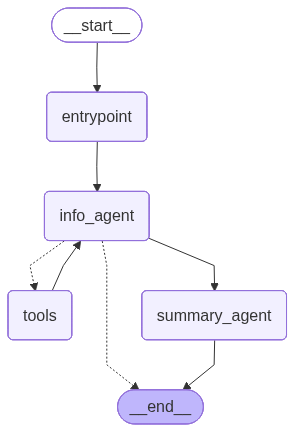

Hi Im the Healthbot Assistant, here to help you understand your diagnoses, your condition,
your treatment options, and your post-treatment care instructions. I can answer any health related
questions you have, and I will quiz you to ensure I achieve my goal to aid you in understanding
how to take proper care of yourself in your post-treatment process..
im at the entry node
about to see if we need searching capability.
About to summarize


In [14]:
#Testing the summary agent and tool calling with summarizer in full effect

workflow = StateGraph(State)

workflow.add_node("entrypoint", entrypoint)
workflow.add_node("info_agent", info_agent)
workflow.add_node("tools", ToolNode([web_search]))
workflow.add_node("summary_agent", summary_agent)

workflow.add_edge(START, "entrypoint")
workflow.add_edge("entrypoint", "info_agent")

workflow.add_conditional_edges(
    source = "info_agent",
    path = router_1,
    path_map = ["tools", END]
)

workflow.add_edge("tools", "info_agent")
workflow.add_edge("info_agent", "summary_agent")
workflow.add_edge("summary_agent", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

result = graph.invoke(
    {
        "topic": "I want to learn about COPD"
    }
)

In [ ]:
g = result["messages"][-1]
print(g)
type(g)

#words = g.split()
#print(len(words))

In [15]:
for message in result["messages"]:
    message.pretty_print()

================================ System Message ================================

You are the Healthbot Assistant, here to help patients understand their diagnoses, conditions,treatment options, and provide them post-treatment care instructions. You should only answer health related questions from the patient.
================================== Ai Message ==================================

What health topic or medical condition do you want to learn about?
================================ Human Message =================================

I want to learn about COPD
================================== Ai Message ==================================

Chronic Obstructive Pulmonary Disease (COPD) is a long-term lung disease that makes it hard to breathe and usually gets worse over time. It mainly includes two conditions:
- **Chronic bronchitis** – long-term inflammation of the airways with mucus and cough
- **Emphysema** – damage to the air sacs (alveoli) in the lungs

### What happens in COPD


In [16]:
result2 = graph.invoke(
    {"topic": "I have sickle cell and i want to make sure i understand the post-treatment care information"}
)

Hi Im the Healthbot Assistant, here to help you understand your diagnoses, your condition,
your treatment options, and your post-treatment care instructions. I can answer any health related
questions you have, and I will quiz you to ensure I achieve my goal to aid you in understanding
how to take proper care of yourself in your post-treatment process..
im at the entry node
about to see if we need searching capability.
About to summarize


In [17]:
for message in result2["messages"]:
    message.pretty_print()

================================ System Message ================================

You are the Healthbot Assistant, here to help patients understand their diagnoses, conditions,treatment options, and provide them post-treatment care instructions. You should only answer health related questions from the patient.
================================== Ai Message ==================================

What health topic or medical condition do you want to learn about?
================================ Human Message =================================

I have sickle cell and i want to make sure i understand the post-treatment care information
================================== Ai Message ==================================

I’ll walk through key post-treatment / ongoing care points for someone living with sickle cell disease (SCD). If you tell me what specific treatment you had (e.g., pain crisis treatment, blood transfusion, hydroxyurea, stem cell transplant, gene therapy, hospitalization for infectio

In [ ]:
def quiz_node(state: State):
# Is this the only node for my quiz and does the quiz need a pydantic input to be able to make sure the user answers the quiz?
    summary = state["summary"]
    sys_message = SystemMessage(
        content=(
            "You are an assistant that quizzes patients with medical conditions. Your job is to look at the previous information shared with the patient and generate a quiz for them, helping to reinforce their understanding of their condition."))
    ai_message = AIMessage(
        content=(
            "Are you ready to take a quiz on the information you were just provided?"))
    state["messages"] + [sys_message + ai_message]
    quiz_question = input("Yes or no: ")
    if quiz_question.lower() == "yes":
        quiz = base_llm.invoke(messages)
        unformatted_quiz = quiz.content
        for m in unformatted_quiz:
            m.pretty_print()
    else:
        return "END"
    return {"messages": messages + [sys_message, ai_message]}

In [ ]:
def router1(state: State):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tool_node"
    return "summarizer"

In [ ]:
def router2(state: State):
    last_message = state["messages"][-1]
    if last_message

In [ ]:
# Create our graph workflow

workflow = StateGraph(State)

#workflow.add_node("entrypoint", entrypoint)
workflow.add_node("agent", agent)
workflow.add_node("tool_node", ToolNode([web_search]))
workflow.add_node("summarizer", summarizer)
workflow.add_node("quiz_node", quiz_node)
##workflow.add_node("node_2", ToolNode([web_search]))
#workflow.add_node("node_3", )
#workflow.add_node("node_4", )
#workflow.add_node("node_5", )

workflow.add_edge(START, "agent")
#workflow.add_edge("agent", "first_agent")

workflow.add_conditional_edges(
    source= "agent",
    path=router1,
    path_map= ["tool_node", "summarizer"]
)

#workflow.add_conditional_edges(
    #source="presenter_node",
   #path=continue_router,
    #path_map=["entrypoint", "END"]
#)

workflow.add_edge("tool_node", "agent")
workflow.add_edge("summarizer", "quiz_node")
workflow.add_edge("quiz_node", END)

In [ ]:

graph = workflow.compile()
#memory = MemorySaver()
#graph = workflow.compile(
#    interrupt_after=["entrypoint"],
#    checkpointer=memory
#)

In [ ]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [ ]:
def human_in_loop_ask_topic(graph: CompiledStateGraph, question:str, thread_id:int):
    topic = {"topic": topic}
    #config = {"configurable": {"thread_id": thread_id}}
    for event in graph.stream(input=topic, stream_mode="values"):
        if not event['messages']:
            continue
        event['messages'][-1].pretty_print()

    human_input = input("Do you approve the tool calling(Y or N)?: ")
        
    if human_input.lower() == "yes":
        for event in graph.stream(input=None, stream_mode="values"):
            if not event['messages']:
                continue
            event['messages'][-1].pretty_print()
    else:
        AIMessage("Please provide a topic that you want to learn about.").pretty_print()


In [ ]:
test = graph.invoke(
    {"topic": "What is COPD?"}
)

print(test)

In [ ]:
for message in test["messages"]:
    message.pretty_print()